# 📓 LSTM Forecasting for Warehouse Utilization (15-Day Horizon)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random


np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [2]:
df = pd.read_csv('sample_data.csv')

In [3]:
df['product_code'] = df['product_id'].astype('category').cat.codes
df['loc_type_code'] = df['location_type'].astype('category').cat.codes

for col in ['on_hand_qty', 'incoming_qty', 'outgoing_qty']:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, input_len=30, output_len=15):
        self.samples = []
        grouped = df.groupby(['product_code', 'loc_type_code'])
        for (pid, lcid), group in grouped:
            group = group.sort_values('day')
            if len(group) < input_len + output_len:
                continue
            for i in range(len(group) - input_len - output_len):
                X = group.iloc[i:i+input_len][['on_hand_qty', 'incoming_qty', 'outgoing_qty']].values
                y = group.iloc[i+input_len:i+input_len+output_len]['location_full'].values
                self.samples.append((X, y))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset = TimeSeriesDataset(df)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [5]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_len=15):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take output of last time step
        out = self.fc(out)
        return out

model = LSTMForecast()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

Epoch 1 | Loss: 16.6448
Epoch 2 | Loss: 6.3217
Epoch 3 | Loss: 5.6796
Epoch 4 | Loss: 3.8389
Epoch 5 | Loss: 2.0122
Epoch 6 | Loss: 1.4466
Epoch 7 | Loss: 1.2542
Epoch 8 | Loss: 1.1742
Epoch 9 | Loss: 1.0469
Epoch 10 | Loss: 0.9695
Epoch 11 | Loss: 0.9795
Epoch 12 | Loss: 0.9464
Epoch 13 | Loss: 0.8610
Epoch 14 | Loss: 0.8602
Epoch 15 | Loss: 0.8407
Epoch 16 | Loss: 0.7690
Epoch 17 | Loss: 0.9001
Epoch 18 | Loss: 0.8886
Epoch 19 | Loss: 0.8036
Epoch 20 | Loss: 0.8050


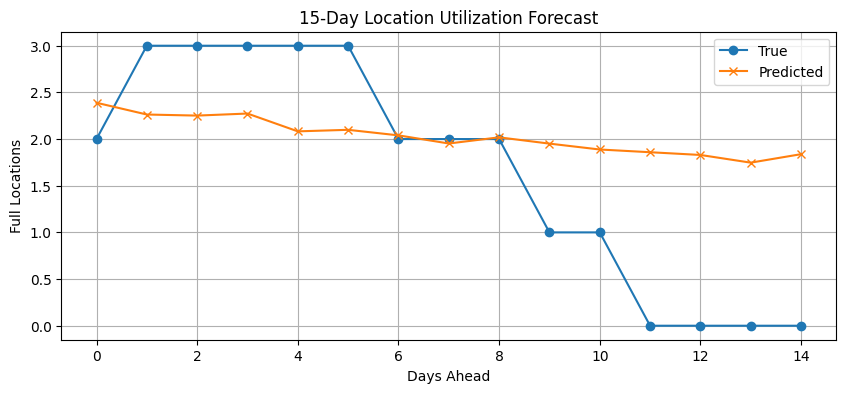

In [7]:
model.eval()
x_sample, y_true = train_dataset[0]
with torch.no_grad():
    y_pred = model(x_sample.unsqueeze(0)).squeeze()

plt.figure(figsize=(10, 4))
plt.plot(range(15), y_true.numpy(), label='True', marker='o')
plt.plot(range(15), y_pred.numpy(), label='Predicted', marker='x')
plt.title("15-Day Location Utilization Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Full Locations")
plt.legend()
plt.grid(True)
plt.show()